<a href="https://colab.research.google.com/github/maimonahST/GP/blob/main/ML_DL_%2B_XAI(shap_eli5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pip

In [1]:
! pip install --upgrade shap tensorflow
! pip install lime
! pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=108404f1df8af53c814268d22ec2d56095cb49ea4c22380b51b9c30b5d217feb
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=c690b2152e25d1ff7718b7af8100dbcb19c32fecdf5fd714e548

# Import

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator
import eli5
import shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare the data for traning

In [4]:
# load data arrays
data_array = np.load('/content/drive/MyDrive/GP/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP/GP-Data/group_array.npy')

label_array = label_array.astype('int')

print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


## Split the data into Training ,Testing and Validation

In [7]:
gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


# X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

# y_val[y_val==0] = 1
# y_val[y_val==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]


In [ ]:
# from sklearn.model_selection import train_test_split


# scaler = StandardScaler3D()
# data_array = scaler.fit_transform(data_array)


# X_train, X_test, y_train, y_test = train_test_split(data_array, label_array, test_size=0.2, random_state=42)

# Models


In [8]:
def fit_and_evaluate(model, X_train, y_train, X_test, y_test):

  model.fit(X_train, y_train)

  # Predictions on the test set
  test_predictions = model.predict(X_test)
  test_accuracy = accuracy_score(y_test, test_predictions)
  print(f"{model.__class__} Tree Test Accuracy:", test_accuracy)
  print("Classification Report (Test):\n", classification_report(y_test, test_predictions))


  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, test_predictions)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix for Decision Tree {model.__class__}")
  plt.show()

  return model

# ML

In [9]:
# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
# X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
# y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

## RF

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


<class 'sklearn.ensemble._forest.RandomForestClassifier'> Tree Test Accuracy: 0.5676066522053507
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.20      0.12      0.15       435
           1       0.66      0.77      0.71       948

    accuracy                           0.57      1383
   macro avg       0.43      0.45      0.43      1383
weighted avg       0.51      0.57      0.53      1383



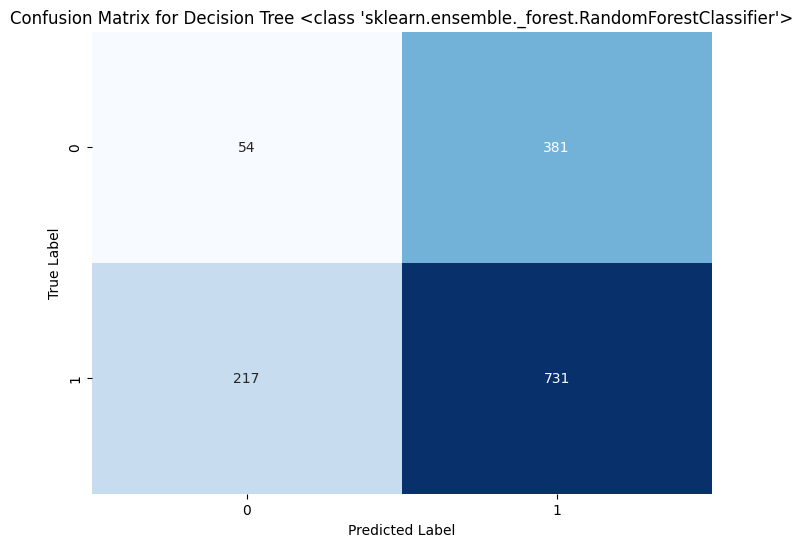

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Build and train Random Forest Classifier
rf_classifier = fit_and_evaluate(RandomForestClassifier(n_estimators=25, random_state=42),
                                 X_train, y_train,
                                 X_test, y_test)

In [11]:
# visualise the weights associated to each feature
eli5.show_weights(rf_classifier)

In [12]:
# visualise the weights associated to each feature related to single test sample
eli5.show_prediction(rf_classifier, X_test[0], show_feature_values=True)

## DT

<class 'sklearn.tree._classes.DecisionTreeClassifier'> Tree Test Accuracy: 0.6854663774403471
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      0.67      0.57       435
           1       0.82      0.69      0.75       948

    accuracy                           0.69      1383
   macro avg       0.66      0.68      0.66      1383
weighted avg       0.72      0.69      0.69      1383



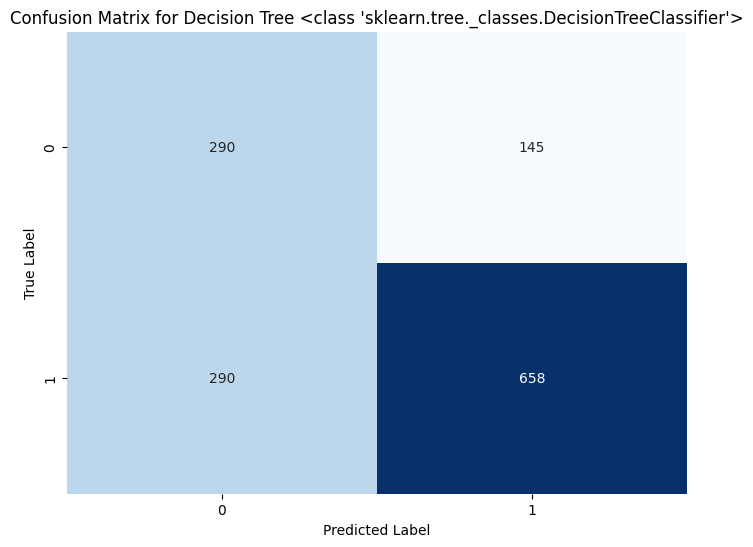

In [14]:
from sklearn.tree import DecisionTreeClassifier
# Build and train Decision Tree Classifier
dt_classifier = fit_and_evaluate(DecisionTreeClassifier(random_state=42),
                                 X_train, y_train, X_test, y_test)

In [15]:
# visualise the weights associated to each feature
eli5.show_weights(dt_classifier)

In [16]:
eli5.show_prediction(dt_classifier, X_test[0], show_feature_values=True)

In [17]:
shap.initjs()
i = 3

explainer = shap.TreeExplainer(dt_classifier)
shap_values = explainer.shap_values(X_test[i])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test[i])

## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Build and train AdaBoost Classifier
adaboost_classifier = fit_and_evaluate(AdaBoostClassifier(random_state=42),
                                       X_train, y_train, X_test, y_test)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


## LR

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


lr Test Accuracy: 0.6854663774403471
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       435
           1       0.69      1.00      0.81       948

    accuracy                           0.69      1383
   macro avg       0.34      0.50      0.41      1383
weighted avg       0.47      0.69      0.56      1383



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

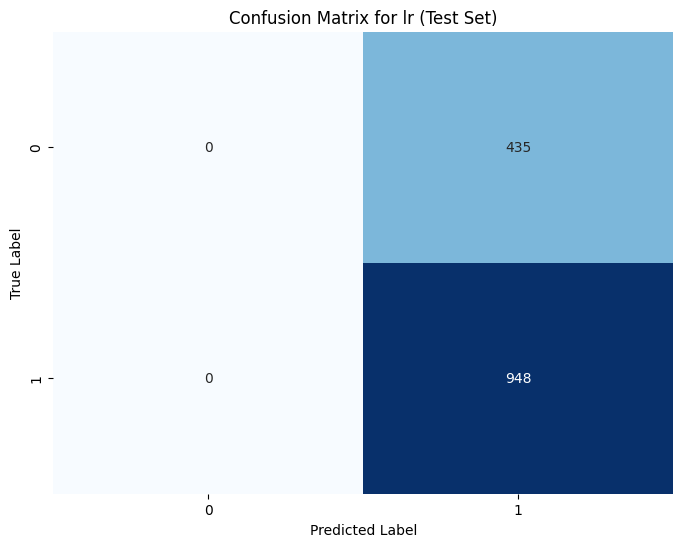

In [ ]:
from sklearn.linear_model import LogisticRegression


# Build and train AdaBoost Classifier
lr_classifier = fit_and_evaluate(LogisticRegression(C = 0.01, solver= 'sag'),
                                 X_train, y_train, X_test, y_test)

## SVC


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svc Test Accuracy: 0.6854663774403471
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       435
           1       0.69      1.00      0.81       948

    accuracy                           0.69      1383
   macro avg       0.34      0.50      0.41      1383
weighted avg       0.47      0.69      0.56      1383



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


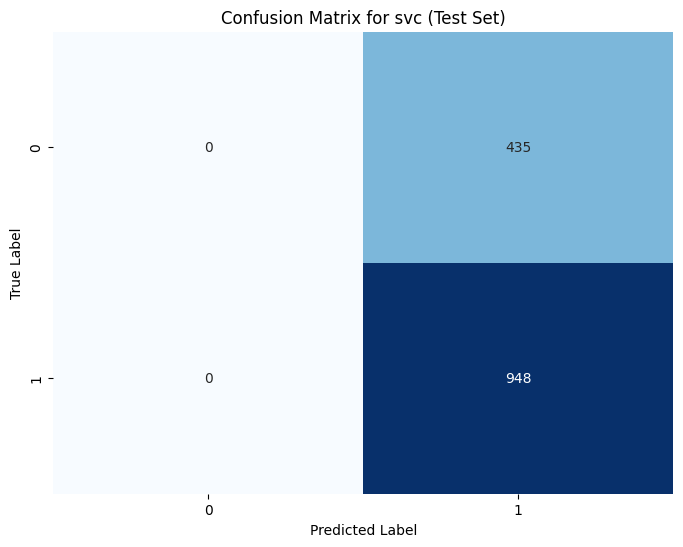

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Build and train AdaBoost Classifier
svc_classifier = fit_and_evaluate(SVC(C=10, gamma=0.001),
                                 X_train, y_train, X_test, y_test)

## Light LGB


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 3406, number of negative: 2361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.512865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10272887
[LightGBM] [Info] Number of data points in the train set: 5767, number of used features: 41250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590602 -> initscore=0.366453
[LightGBM] [Info] Start training from score 0.366453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Optimized LightGBM Test Accuracy: 0.6767895878524945
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.49      0.66      0.56       435
           1       0.81      0.69      0.74       948

    accuracy                           0.68      1383
   macro avg       0.65      0.67      0.65      138

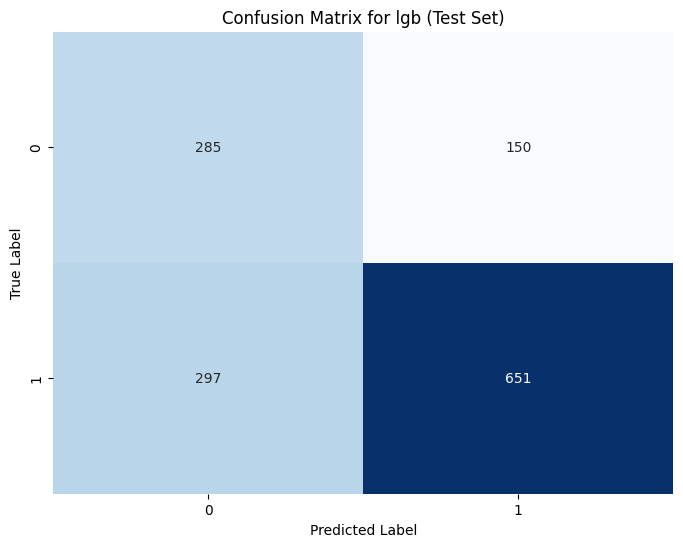

In [ ]:
import lightgbm as lgb

# Define the LightGBM model
lgb_model = fit_and_evaluate(lgb.LGBMClassifier(n_estimators = 20),
                                 X_train, y_train, X_test, y_test)

## Naive Bayaes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train the Naive Bayes
nb_model = fit_and_evaluate(GaussianNB(),
                                 X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimized Naive Bayes Test Accuracy: 0.4909616775126536
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.31      0.52      0.39       435
           1       0.68      0.48      0.56       948

    accuracy                           0.49      1383
   macro avg       0.50      0.50      0.48      1383
weighted avg       0.57      0.49      0.51      1383



## KNN


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Optimized KNN Test Accuracy: 0.5234996384671005
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.33      0.51      0.40       435
           1       0.70      0.53      0.60       948

    accuracy                           0.52      1383
   macro avg       0.52      0.52      0.50      1383
weighted avg       0.59      0.52      0.54      1383



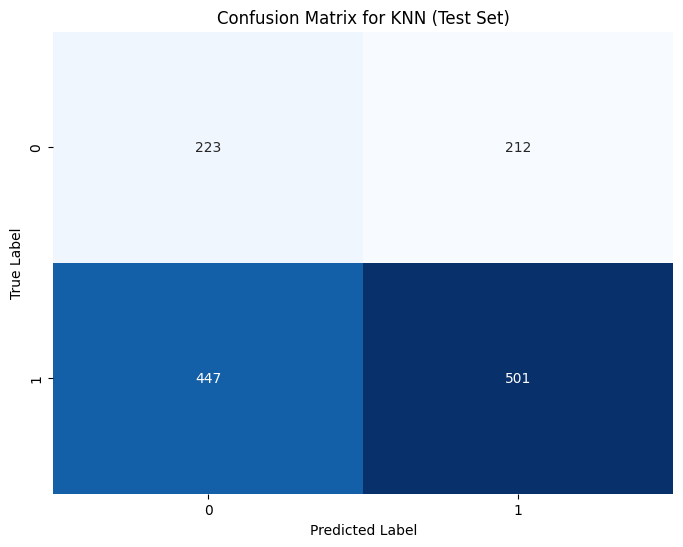

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = fit_and_evaluate(KNeighborsClassifier(n_neighbors=3),
                                 X_train, y_train, X_test, y_test)


## Ensemble of ML models

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 3406, number of negative: 2361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.372343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10272887
[LightGBM] [Info] Number of data points in the train set: 5767, number of used features: 41250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590602 -> initscore=0.366453
[LightGBM] [Info] Start training from score 0.366453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
voting Test Accuracy: 0.7678958785249458
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.64      0.60      0.62       435
           1       0.82      0.84      0.83       948

    accuracy                           0.77      1383
   macro avg       0.73      0.72      0.73      1383
weighted a

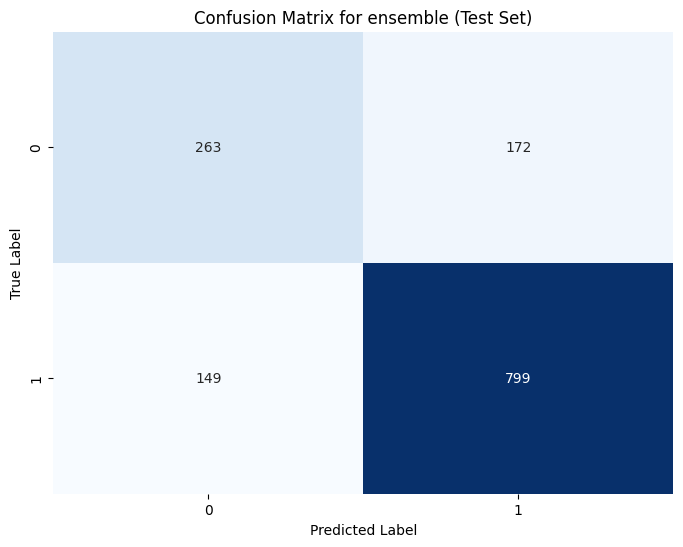

In [ ]:
# prompt: write several ML models

# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Define the list of models
models = [
    ("Random Forest", RandomForestClassifier(n_estimators=20, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Light GBM", lgb.LGBMClassifier(n_estimators = 20) ),
    ("GaussianNB", GaussianNB()),
    ( "KNN", KNeighborsClassifier(n_neighbors=3))
]

# Create a voting classifier
voting_classifier = fit_and_evaluate(VotingClassifier(estimators=models, voting='hard'),
                                 X_train, y_train, X_test, y_test)


# DL

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=( 1250, 33))

# Create the first block
block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=2)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
model = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using training features and labels
hist = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
37/37 [==============================] - 6s 67ms/step - loss: 0.0732 - accuracy: 0.9998 - val_loss: 2.5477 - val_accuracy: 0.6855
Epoch 2/100
37/37 [==============================] - 1s 39ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 3.1216 - val_accuracy: 0.6855
Epoch 3/100
37/37 [==============================] - 1s 39ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.5041 - val_accuracy: 0.6855
Epoch 4/100
37/37 [==============================] - 1s 39ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.9429 - val_accuracy: 0.6855
Epoch 5/100
37/37 [==============================] - 1s 39ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 4.4850 - val_accuracy: 0.6855
Epoch 6/100
37/37 [==============================] - 1s 39ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 5.0254 - val_accuracy: 0.6855


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)


# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

45/45 [==============================] - 1s 4ms/step
Accuracy: 0.9664335664335665
Recall: 0.9667812142038946
Precision: 0.9779837775202781
F1-score: 0.9723502304147466


Average Confusion Matrix:


<Figure size 800x600 with 0 Axes>

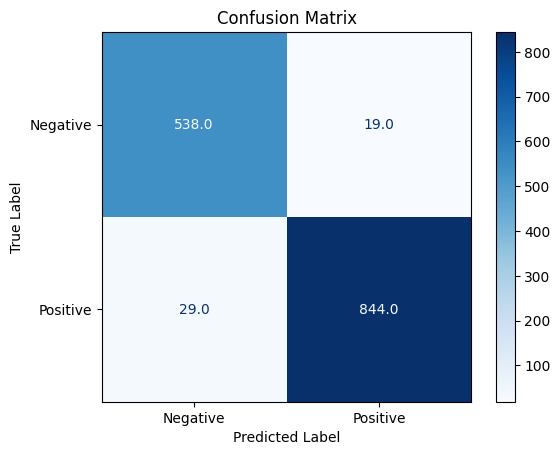

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       557
           1       0.98      0.97      0.97       873

    accuracy                           0.97      1430
   macro avg       0.96      0.97      0.96      1430
weighted avg       0.97      0.97      0.97      1430



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_binary)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test, y_pred_binary)

# Print the report
print(report)

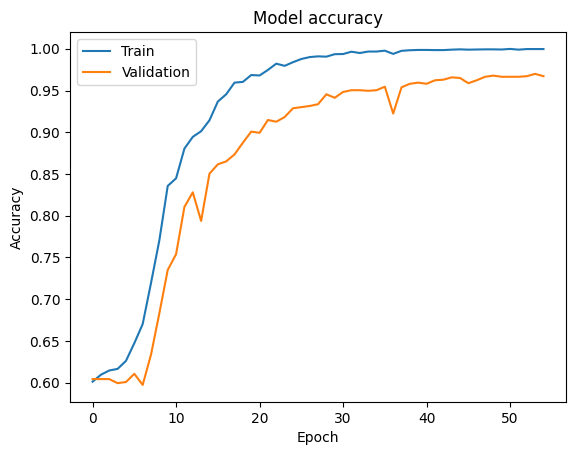

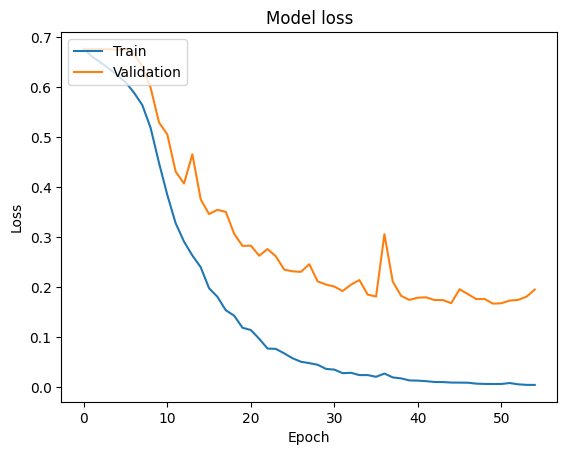

In [ ]:
# plot model accuracy and loss of training and validation
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import shap
shap.initjs()

# Create a KernelExplainer instance
explainer = shap.KernelExplainer(model, X_train)

# Explain individual predictions
explainer.explain_row(
    X_test[0], max_evals=50,  # Adjust as needed
    main_effects=True,
    error_bounds="shap",  # Choose error bound method
    outputs=1,  # Specify output index if applicable (multi-output models)
    silent=False  # Set to True to suppress status messages
)

# Visualize explanations using row_values
shap.force_plot(explainer.expected_value,X_test[0] )


## CNN-RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x


# Define the input layer with a shape of (1250, 33)
input = Input(shape=(1250, 33))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)




In [ ]:
from tensorflow.keras.layers import GRU, LeakyReLU, concatenate


gru_out1 = GRU(32, activation=LeakyReLU(alpha=0.01), return_sequences=True)(block3)
gru_out2 = GRU(32, activation=LeakyReLU(alpha=0.01), return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1, gru_out2], axis=2)
gru_out3 = GRU(32, activation=LeakyReLU(alpha=0.01), return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1, gru_out2, gru_out3])
gru_out4 = GRU(32, activation=LeakyReLU(alpha=0.01))(gru_out)



In [ ]:
# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
model = Model(inputs=input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1250, 33)]           0         []                            
                                                                                                  
 conv1d_9 (Conv1D)           (None, 625, 32)              2144      ['input_2[0][0]']             
                                                                                                  
 conv1d_10 (Conv1D)          (None, 625, 32)              4256      ['input_2[0][0]']             
                                                                                                  
 conv1d_11 (Conv1D)          (None, 625, 32)              8480      ['input_2[0][0]']             
                                                                                            

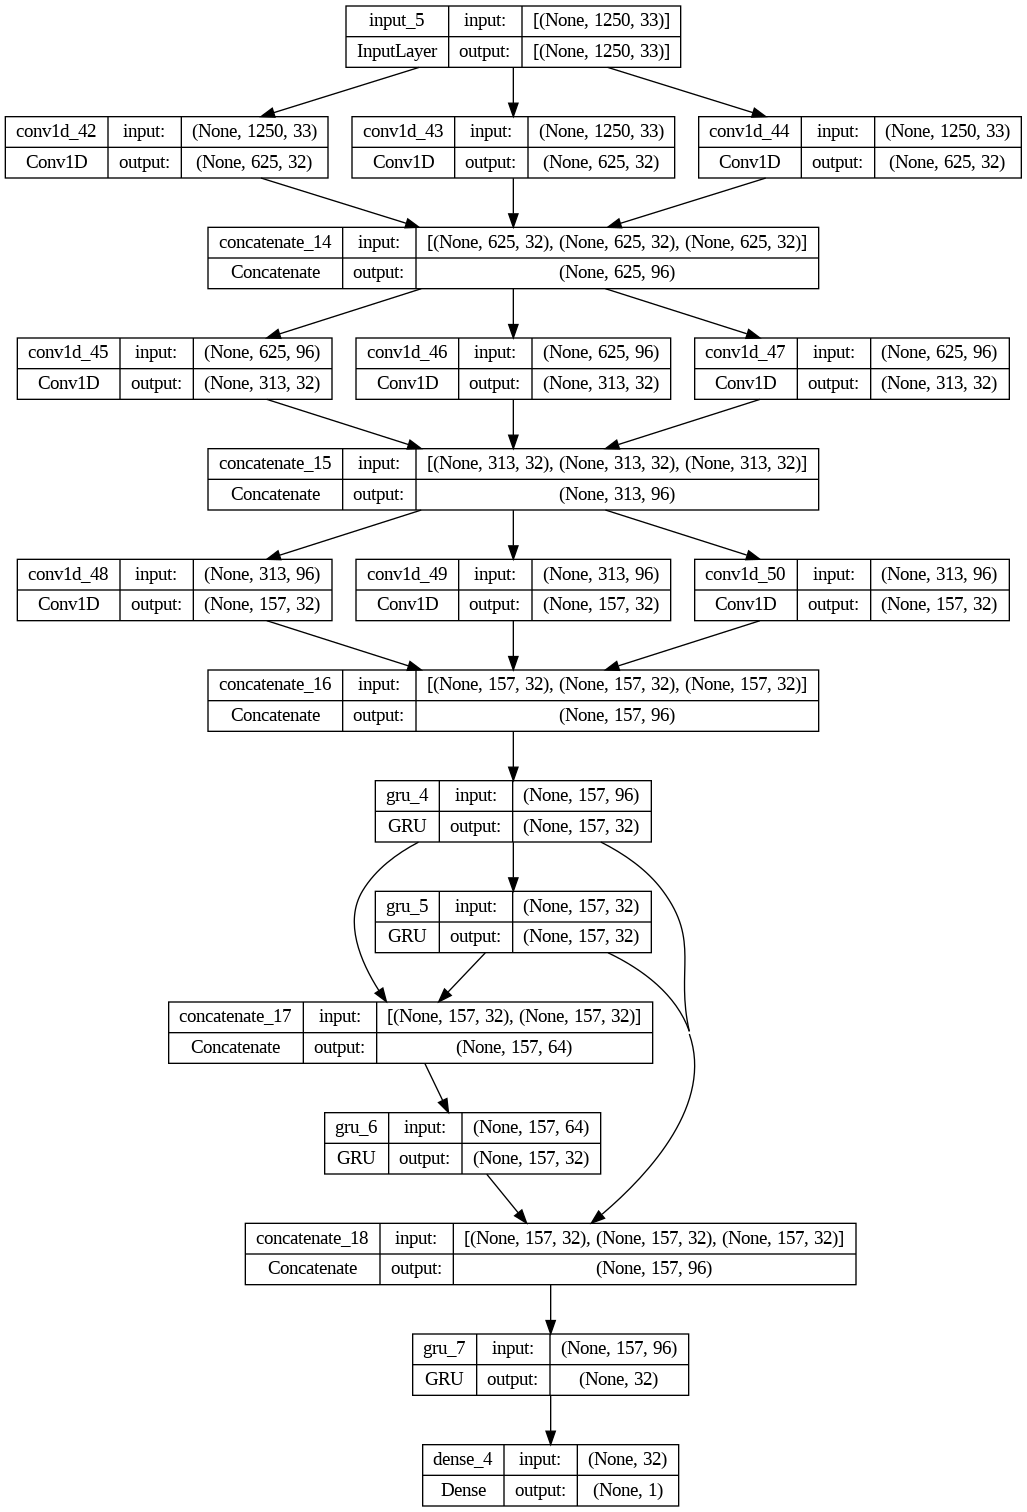

In [ ]:

tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import Hinge
# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)


# loss_function = MeanSquaredError()
loss_function ='binary_crossentropy'
# loss_function = Hinge()


# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss= loss_function, metrics=['accuracy'])


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using training features and labels
hist = model.fit(X_train, y_train,
                 epochs=50,
                 batch_size=132,
                 validation_data=(X_test, y_test),
                 callbacks=early_stopping)


Epoch 1/50
44/44 [==============================] - 42s 795ms/step - loss: 0.6515 - accuracy: 0.6114 - val_loss: 0.6503 - val_accuracy: 0.6175
Epoch 2/50
44/44 [==============================] - 33s 745ms/step - loss: 0.6375 - accuracy: 0.6227 - val_loss: 0.6419 - val_accuracy: 0.6224
Epoch 3/50
44/44 [==============================] - 32s 736ms/step - loss: 0.6176 - accuracy: 0.6418 - val_loss: 0.6347 - val_accuracy: 0.6203
Epoch 4/50
44/44 [==============================] - 33s 739ms/step - loss: 0.5933 - accuracy: 0.6747 - val_loss: 0.6181 - val_accuracy: 0.6343
Epoch 5/50
44/44 [==============================] - 33s 742ms/step - loss: 0.5586 - accuracy: 0.7084 - val_loss: 0.6020 - val_accuracy: 0.6741
Epoch 6/50
44/44 [==============================] - 33s 745ms/step - loss: 0.5253 - accuracy: 0.7372 - val_loss: 0.5997 - val_accuracy: 0.6762
Epoch 7/50
44/44 [==============================] - 33s 740ms/step - loss: 0.4920 - accuracy: 0.7622 - val_loss: 0.5759 - val_accuracy: 0.6958

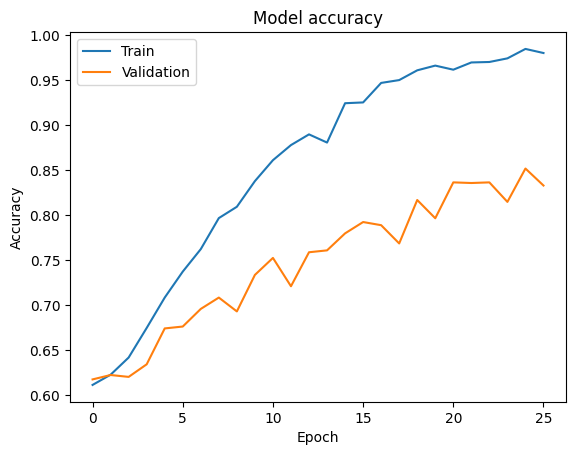

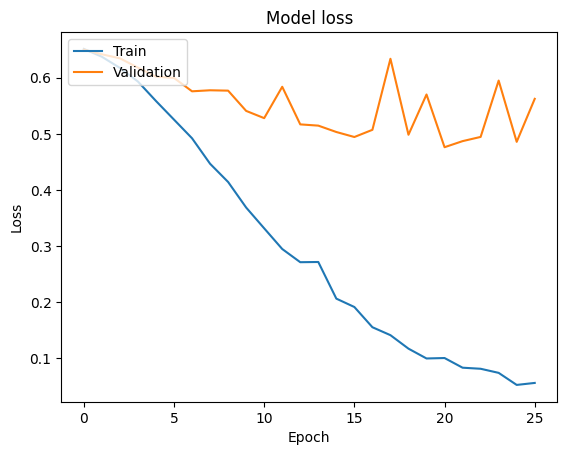

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

45/45 [==============================] - 6s 99ms/step
Accuracy: 0.8363636363636363
Recall: 0.8751431844215349
Precision: 0.859392575928009
F1-score: 0.8671963677639046


Average Confusion Matrix:


<Figure size 800x600 with 0 Axes>

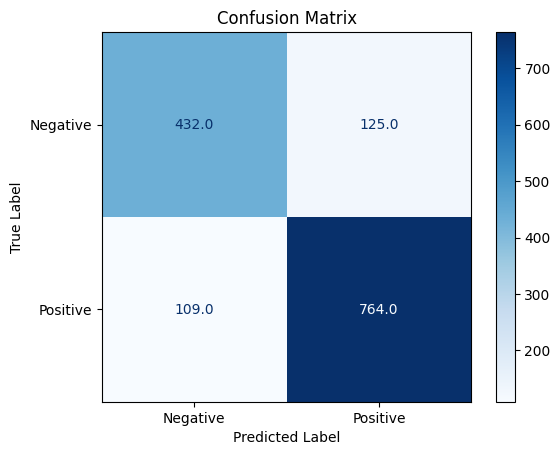

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       557
           1       0.86      0.88      0.87       873

    accuracy                           0.84      1430
   macro avg       0.83      0.83      0.83      1430
weighted avg       0.84      0.84      0.84      1430



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_binary)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test, y_pred_binary)

# Print the report
print(report)

# Stacking Model

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.base import clone


# Base models
model1 = RandomForestClassifier(random_state=42)
model2 = GradientBoostingClassifier(random_state=42)

# Meta model
meta_model = LogisticRegression()

# Stacking function
def stacking(models, meta_model, X_train, y_train, X_test, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    meta_features_train = np.zeros((X_train.shape[0], len(models)))

    for i, model in enumerate(models):
        clone_model = clone(model)
        for train_fold, holdout_fold in kfold.split(X_train, y_train):
            clone_model.fit(X_train[train_fold], y_train[train_fold])
            meta_features_train[holdout_fold, i] = clone_model.predict(X_train[holdout_fold])

    meta_model.fit(meta_features_train, y_train)

    meta_features_test = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        meta_features_test[:, i] = model.predict(X_test)

    stacked_predictions = meta_model.predict(meta_features_test)

    return stacked_predictions

# Stack models and get predictions
stacked_predictions = stacking([model1, model2], meta_model, X_train, y_train, X_test)

# Evaluate stacked model
accuracy = accuracy_score(y_test, stacked_predictions)
print(f"Stacked Model Accuracy: {accuracy}")


<ipython-input-62-504af9e04854>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clone_model.fit(X_train[train_fold], y_train[train_fold])
<ipython-input-62-504af9e04854>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clone_model.fit(X_train[train_fold], y_train[train_fold])
<ipython-input-62-504af9e04854>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clone_model.fit(X_train[train_fold], y_train[train_fold])
<ipython-input-62-504af9e04854>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clone_model.fit(X_train[train_fold], y_train[train_fol